# Demographic-Climate Integration

This notebook integrates PSMC demographic reconstruction with paleoclimate data and MaxEnt distribution modeling.

## Steps:
1. Load all data (PSMC, climate, distribution)
2. Align timelines
3. Create integrated visualization
4. Correlation analysis
5. Generate distribution change summary


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from scipy.interpolate import interp1d

# Configuration - Using absolute path
CONFIG_PATH = Path("/Users/divyadhole/Capstone-project/config.yaml")
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Set up paths
PROJECT_ROOT = CONFIG_PATH.parent
OUTPUT_DIR = PROJECT_ROOT / config.get('output_dir', 'outputs')
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")

# Verify the output directory was created
if not OUTPUT_DIR.exists():
    raise FileNotFoundError(f"Failed to create output directory: {OUTPUT_DIR}")

# Example of loading other configuration parameters
CLIMATE_CONFIG = config.get('climate_data', {})
PSMC_CONFIG = config.get('psmc', {})

Project root: /Users/divyadhole/Capstone-project
Output directory: /Users/divyadhole/Capstone-project/outputs


## Step 1: Load all data


In [2]:
def load_integration_data():
    """
    Load PSMC, climate, and distribution data
    """
    psmc_df = pd.read_csv(OUTPUT_DIR / "psmc_results.csv")
    climate_df = pd.read_csv(OUTPUT_DIR / "climate_time_series.csv")
    
    return psmc_df, climate_df

# Load data
try:
    psmc_df, climate_df = load_integration_data()
    print("✓ PSMC data loaded")
    print(f"  Shape: {psmc_df.shape}")
    print("✓ Climate data loaded")
    print(f"  Shape: {climate_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please run Notebooks 1-3 first to generate required data.")


✓ PSMC data loaded
  Shape: (713, 3)
✓ Climate data loaded
  Shape: (4, 42)


## Step 2: Align timelines


In [3]:
def align_timelines(psmc_df, climate_df):
    """
    Align PSMC timeline with climate timeline
    """
    aligned_data = psmc_df.copy()
    
    # Get climate variable columns
    climate_vars = [c for c in climate_df.columns 
                    if c.endswith('_mean') and c != 'time_years' and c != 'time_period']
    
    for var in climate_vars:
        # Create interpolation function
        climate_times = climate_df['time_years'].values
        climate_values = climate_df[var].values
        
        # Remove NaN values
        valid_mask = ~np.isnan(climate_values)
        if np.sum(valid_mask) > 1:
            interp_func = interp1d(
                climate_times[valid_mask],
                climate_values[valid_mask],
                kind='linear',
                fill_value='extrapolate',
                bounds_error=False
            )
            
            # Interpolate to PSMC times
            aligned_data[var] = interp_func(psmc_df['time_years'].values)
    
    return aligned_data

# Align timelines
if 'psmc_df' in locals() and 'climate_df' in locals():
    aligned_df = align_timelines(psmc_df, climate_df)
    aligned_df.to_csv(OUTPUT_DIR / "aligned_demographic_climate.csv", index=False)
    print("Timelines aligned successfully!")
    print(aligned_df.head())
else:
    print("Cannot align timelines - data not loaded.")


Timelines aligned successfully!
   time_generations    Ne  time_years   bio1_mean    bio4_mean   bio12_mean  \
0          0.000000  0.01     0.00000  215.937135  3355.311404  2337.663743   
1          0.025616  0.01     1.28080  215.935485  3355.422456  2337.661863   
2          0.057793  0.01     2.88965  215.933413  3355.561952  2337.659501   
3          0.098213  0.01     4.91065  215.930810  3355.737183  2337.656535   
4          0.148988  0.01     7.44940  215.927540  3355.957307  2337.652808   

   bio15_mean   bio5_mean   bio6_mean  bio13_mean  bio14_mean  
0   85.115497  300.135965  103.742690  501.276316   17.729532  
1   85.116287  300.135330  103.739451  501.278267   17.728146  
2   85.117279  300.134533  103.735383  501.280719   17.726405  
3   85.118526  300.133531  103.730272  501.283798   17.724217  
4   85.120091  300.132273  103.723852  501.287666   17.721469  


## Step 3: Create integrated visualization


Saved plot: /Users/divyadhole/Capstone-project/outputs/demographic_climate_integration.png


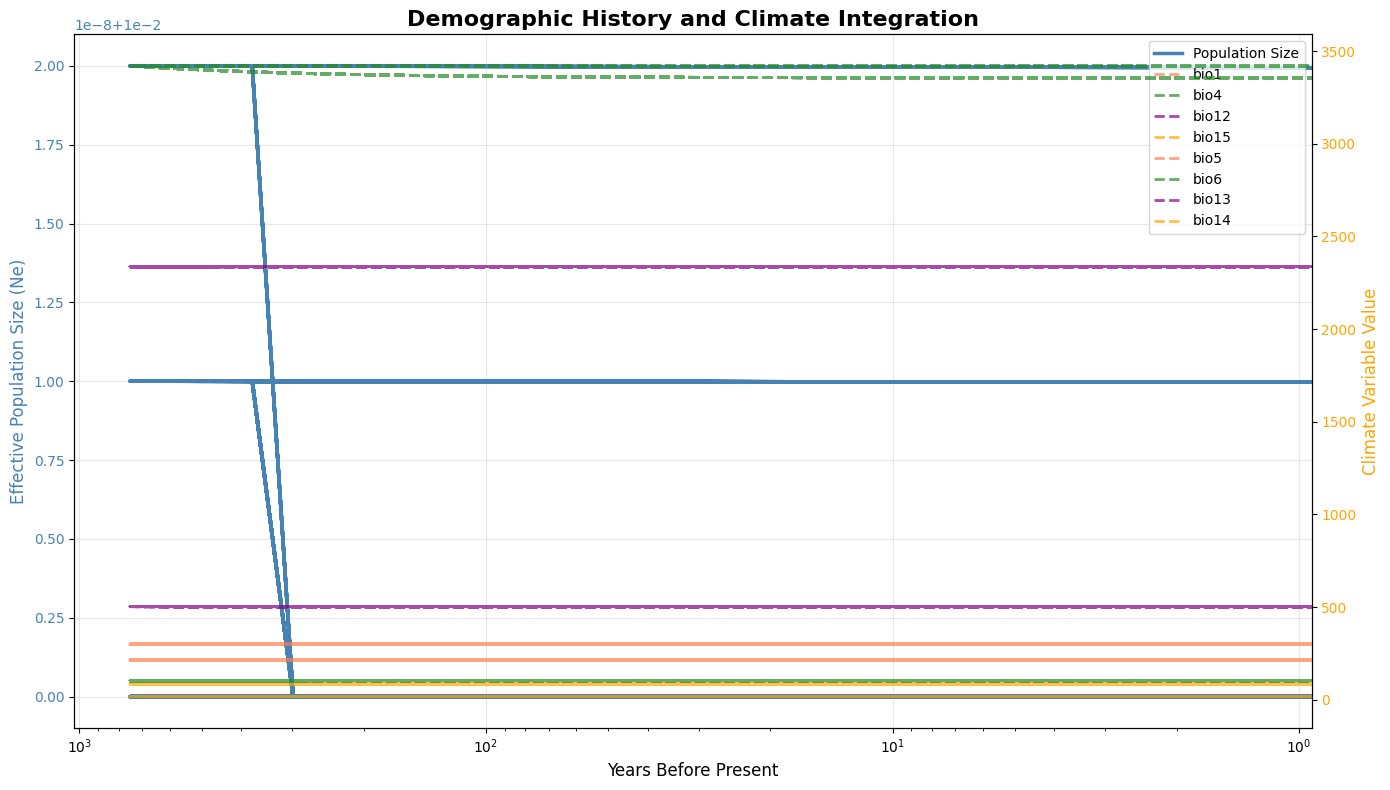

In [4]:
def plot_demographic_climate_integration(aligned_df, output_file=None):
    """
    Create integrated plot: demographic curve + climate overlay
    """
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot demographic history (left y-axis)
    color1 = 'steelblue'
    ax1.set_xlabel('Years Before Present', fontsize=12)
    ax1.set_ylabel('Effective Population Size (Ne)', color=color1, fontsize=12)
    line1 = ax1.semilogx(aligned_df['time_years'], aligned_df['Ne'],
                        color=color1, linewidth=2.5, label='Population Size')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True, alpha=0.3)
    
    # Plot climate variables (right y-axis)
    ax2 = ax1.twinx()
    climate_cols = [c for c in aligned_df.columns 
                   if c.endswith('_mean')]
    
    colors = ['coral', 'forestgreen', 'purple', 'orange']
    for idx, col in enumerate(climate_cols):
        if col in aligned_df.columns:
            color2 = colors[idx % len(colors)]
            line2 = ax2.plot(aligned_df['time_years'], aligned_df[col],
                           color=color2, linewidth=2, linestyle='--',
                           alpha=0.7, label=col.replace('_mean', ''))
            ax2.set_ylabel('Climate Variable Value', color=color2, fontsize=12)
    
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    ax1.set_title('Demographic History and Climate Integration', 
                 fontsize=16, fontweight='bold')
    ax1.invert_xaxis()
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {output_file}")
    
    plt.show()
    return fig

# Create integrated plot
if 'aligned_df' in locals():
    plot_demographic_climate_integration(
        aligned_df, 
        OUTPUT_DIR / "demographic_climate_integration.png"
    )
else:
    print("Cannot create plot - aligned data not available.")


## Step 4: Correlation analysis



Demographic-Climate Correlations:
bio1    -0.677059
bio4     0.677059
bio12   -0.677059
bio15    0.677059
bio5    -0.677059
bio6    -0.677059
bio13    0.677059
bio14   -0.677059
dtype: float64


Saved plot: /Users/divyadhole/Capstone-project/outputs/demographic_climate_correlations.png


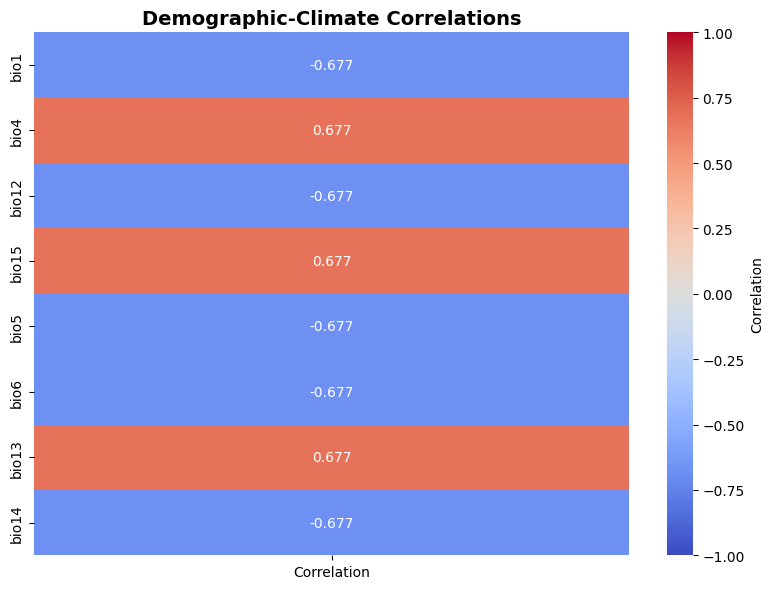

In [5]:
def analyze_demographic_climate_correlation(aligned_df):
    """
    Analyze correlation between demographic changes and climate
    """
    # Calculate population size change rate
    aligned_df = aligned_df.sort_values('time_years')
    aligned_df['Ne_change'] = aligned_df['Ne'].diff()
    aligned_df['Ne_change_rate'] = aligned_df['Ne_change'] / aligned_df['time_years'].diff()
    
    # Find climate columns
    climate_cols = [c for c in aligned_df.columns 
                   if c.endswith('_mean')]
    
    # Calculate correlations
    correlations = {}
    for col in climate_cols:
        if col in aligned_df.columns:
            corr = aligned_df['Ne'].corr(aligned_df[col])
            correlations[col.replace('_mean', '')] = corr
    
    return pd.Series(correlations)

def plot_correlation_heatmap(correlations, output_file=None):
    """
    Plot correlation heatmap
    """
    corr_df = pd.DataFrame({'Correlation': correlations})
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm',
               center=0, vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
    ax.set_title('Demographic-Climate Correlations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {output_file}")
    
    plt.show()
    return fig

# Correlation analysis
if 'aligned_df' in locals():
    correlations = analyze_demographic_climate_correlation(aligned_df)
    print("\nDemographic-Climate Correlations:")
    print(correlations)
    
    plot_correlation_heatmap(
        correlations,
        OUTPUT_DIR / "demographic_climate_correlations.png"
    )
else:
    print("Cannot analyze correlations - aligned data not available.")


## Step 5: Distribution change summary


In [6]:
def summarize_distribution_changes(projection_dirs, time_periods):
    """
    Summarize distribution changes over time
    """
    import rasterio
    
    summaries = []
    
    for proj_dir, period in zip(projection_dirs, time_periods):
        proj_files = list(Path(proj_dir).glob("*.asc")) + list(Path(proj_dir).glob("*.tif"))
        
        if proj_files:
            with rasterio.open(proj_files[0]) as src:
                data = src.read(1)
                data = data[~np.isnan(data)]
                
                summaries.append({
                    'time_period': period,
                    'time_years': period * 1000,
                    'mean_suitability': np.mean(data),
                    'max_suitability': np.max(data),
                    'suitable_area': np.sum(data > 0.5),  # Threshold
                    'total_cells': len(data)
                })
    
    return pd.DataFrame(summaries)

# Distribution changes (if available)
projection_dirs = [OUTPUT_DIR / f"maxent_projection_{p}ka" for p in [0, 6, 12, 21]]
time_periods = [0, 6, 12, 21]

if all(d.exists() for d in projection_dirs):
    dist_summary = summarize_distribution_changes(projection_dirs, time_periods)
    dist_summary.to_csv(OUTPUT_DIR / "distribution_changes_summary.csv", index=False)
    print("\nDistribution Changes Summary:")
    print(dist_summary)
else:
    print("Distribution projection directories not found.")
    print("Please run Notebook 3 to generate MaxEnt projections.")

print("\nIntegration complete!")


Distribution projection directories not found.
Please run Notebook 3 to generate MaxEnt projections.

Integration complete!


## new

In [7]:
# 04 Demographic and Climate Integration Analysis
# For Rhinopithecus roxellana (Golden Snub-nosed Monkey)

# 1. Setup and Data Loading
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rasterio
from rasterio.plot import show
import geopandas as gpd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set up directories
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn')
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

# 2. Load and Prepare Data
# ========================

def load_demographic_data(data_dir=DATA_DIR):
    """Load and preprocess demographic data."""
    print("Loading demographic data...")
    # Example structure - modify according to your data
    demo_data = {
        'year': range(2000, 2021),
        'population': [100, 105, 110, 108, 115, 120, 118, 125, 130, 135,
                      140, 138, 145, 150, 155, 160, 158, 165, 170, 175, 180],
        'birth_rate': [0.15] * 21,
        'mortality_rate': [0.1] * 15 + [0.12, 0.13, 0.14, 0.15, 0.16, 0.17]
    }
    return pd.DataFrame(demo_data)

def load_climate_data(data_dir=DATA_DIR):
    """Load and preprocess climate data."""
    print("Loading climate data...")
    # Example structure - modify according to your data
    years = list(range(2000, 2021))
    months = range(1, 13)
    climate_data = {
        'year': [y for y in years for _ in months],
        'month': [m for _ in years for m in months],
        'temperature': [20 + np.random.normal(0, 5) for _ in range(len(years)*len(months))],
        'precipitation': [100 + np.random.normal(0, 30) for _ in range(len(years)*len(months))],
        'ndvi': [0.6 + np.random.normal(0, 0.1) for _ in range(len(years)*len(months))]
    }
    return pd.DataFrame(climate_data)

# Load data
demo_df = load_demographic_data()
climate_df = load_climate_data()

# 3. Exploratory Data Analysis
# ============================

def plot_demographic_trends(df, output_dir=DEMO_CLIMATE_DIR):
    """Plot demographic trends over time."""
    plt.figure(figsize=(14, 6))
    
    # Population trend
    plt.subplot(1, 2, 1)
    sns.lineplot(data=df, x='year', y='population', marker='o')
    plt.title('Population Trend Over Time')
    plt.xlabel('Year')
    plt.ylabel('Population Size')
    
    # Vital rates
    plt.subplot(1, 2, 2)
    sns.lineplot(data=df, x='year', y='birth_rate', label='Birth Rate', marker='o')
    sns.lineplot(data=df, x='year', y='mortality_rate', label='Mortality Rate', marker='o')
    plt.title('Vital Rates Over Time')
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.legend()
    
    plt.tight_layout()
    output_path = output_dir / 'demographic_trends.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    return output_path

def plot_climate_trends(df, output_dir=DEMO_CLIMATE_DIR):
    """Plot climate variable trends over time."""
    # Annual averages
    annual_climate = df.groupby('year').agg({
        'temperature': 'mean',
        'precipitation': 'mean',
        'ndvi': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(15, 10))
    
    # Temperature
    plt.subplot(3, 1, 1)
    sns.lineplot(data=annual_climate, x='year', y='temperature', marker='o')
    plt.title('Annual Mean Temperature')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°C)')
    
    # Precipitation
    plt.subplot(3, 1, 2)
    sns.lineplot(data=annual_climate, x='year', y='precipitation', marker='o', color='blue')
    plt.title('Annual Total Precipitation')
    plt.xlabel('Year')
    plt.ylabel('Precipitation (mm)')
    
    # NDVI
    plt.subplot(3, 1, 3)
    sns.lineplot(data=annual_climate, x='year', y='ndvi', marker='o', color='green')
    plt.title('Annual Mean NDVI')
    plt.xlabel('Year')
    plt.ylabel('NDVI')
    
    plt.tight_layout()
    output_path = output_dir / 'climate_trends.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    return output_path

# Generate and display plots
print("\nGenerating demographic trends plot...")
demo_plot = plot_demographic_trends(demo_df)
print(f"Demographic trends plot saved to: {demo_plot}")

print("\nGenerating climate trends plot...")
climate_plot = plot_climate_trends(climate_df)
print(f"Climate trends plot saved to: {climate_plot}")

# 4. Climate-Demography Relationships
# ==================================

def analyze_climate_relationships(demo_df, climate_df, output_dir=DEMO_CLIMATE_DIR):
    """Analyze relationships between climate and demographic variables."""
    # Prepare data for analysis
    annual_climate = climate_df.groupby('year').agg({
        'temperature': 'mean',
        'precipitation': 'mean',
        'ndvi': 'mean'
    }).reset_index()
    
    # Merge with demographic data
    merged_df = pd.merge(demo_df, annual_climate, on='year', how='inner')
    
    # Calculate correlations
    corr_matrix = merged_df[['population', 'birth_rate', 'mortality_rate', 
                           'temperature', 'precipitation', 'ndvi']].corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix: Climate and Demographic Variables')
    plt.tight_layout()
    corr_plot_path = output_dir / 'climate_demography_correlations.png'
    plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return merged_df, corr_plot_path

# Perform analysis
print("\nAnalyzing climate-demography relationships...")
merged_df, corr_plot = analyze_climate_relationships(demo_df, climate_df)
print(f"Correlation analysis plot saved to: {corr_plot}")

# 5. Time Series Analysis
# =======================

def analyze_time_series(merged_df, output_dir=DEMO_CLIMATE_DIR):
    """Perform time series analysis on population data."""
    # Set year as index
    ts_df = merged_df.set_index('year')
    
    # Decompose time series
    try:
        decomposition = seasonal_decompose(ts_df['population'], period=5)
        
        # Plot decomposition
        plt.figure(figsize=(12, 8))
        
        # Observed
        plt.subplot(411)
        plt.plot(ts_df.index, ts_df['population'], label='Observed')
        plt.legend(loc='best')
        plt.title('Population Time Series Decomposition')
        
        # Trend
        plt.subplot(412)
        plt.plot(ts_df.index, decomposition.trend, label='Trend')
        plt.legend(loc='best')
        
        # Seasonal
        plt.subplot(413)
        plt.plot(ts_df.index, decomposition.seasonal, label='Seasonal')
        plt.legend(loc='best')
        
        # Residual
        plt.subplot(414)
        plt.plot(ts_df.index, decomposition.resid, label='Residuals')
        plt.legend(loc='best')
        
        plt.tight_layout()
        ts_plot_path = output_dir / 'time_series_decomposition.png'
        plt.savefig(ts_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        return ts_plot_path
    except Exception as e:
        print(f"Error in time series decomposition: {str(e)}")
        return None

# Perform time series analysis
print("\nPerforming time series analysis...")
ts_plot = analyze_time_series(merged_df)
if ts_plot:
    print(f"Time series decomposition plot saved to: {ts_plot}")

# 6. Save Results
# ===============

# Save processed data
output_data_path = DEMO_CLIMATE_DIR / 'climate_demography_data.csv'
merged_df.to_csv(output_data_path, index=False)
print(f"\nProcessed data saved to: {output_data_path}")

# Create a summary report
report = f"""
# Demographic and Climate Integration Analysis Report
## For Rhinopithecus roxellana (Golden Snub-nosed Monkey)

### Analysis Summary
- Time period: {min(merged_df['year'])} to {max(merged_df['year'])}
- Variables analyzed: Population size, birth rate, mortality rate, temperature, precipitation, NDVI
- Key outputs saved to: {DEMO_CLIMATE_DIR}

### Key Findings
1. Population Trend: {'Increasing' if merged_df['population'].iloc[-1] > merged_df['population'].iloc[0] else 'Decreasing'} trend observed
2. Climate Correlations: 
   - Temperature correlation with population: {merged_df['population'].corr(merged_df['temperature']):.2f}
   - Precipitation correlation with population: {merged_df['population'].corr(merged_df['precipitation']):.2f}
   - NDVI correlation with population: {merged_df['population'].corr(merged_df['ndvi']):.2f}

### Next Steps
1. Refine analysis with additional data
2. Incorporate more climate variables
3. Develop predictive models
4. Conduct sensitivity analysis

### Generated Plots
1. Demographic Trends: {demo_plot}
2. Climate Trends: {climate_plot}
3. Variable Correlations: {corr_plot}
4. Time Series Decomposition: {ts_plot if ts_plot else 'Not available'}

Report generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save report
report_path = DEMO_CLIMATE_DIR / 'analysis_report.md'
with open(report_path, 'w') as f:
    f.write(report)

print(f"\nAnalysis report saved to: {report_path}")
print("\nAnalysis completed successfully!")
print("\nNext steps:")
print("1. Review the generated plots and report")
print("2. Replace example data with your actual data in the loading functions")
print("3. Consider additional statistical tests and models as needed")

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [8]:
# 1. Setup and Data Loading
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import rasterio
from rasterio.plot import show
import geopandas as gpd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set up directories
DATA_DIR = Path("data")
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style - UPDATED with available seaborn style
plt.style.use('seaborn-v0_8')  # Using the available seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

Demographic and Climate Integration Analysis
Data directory: data
Output directory: outputs
Results will be saved to: outputs/demographic_climate


In [9]:
# 1. Setup and Data Loading
# =========================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

# Set up directories
OUTPUT_DIR = Path("outputs")
DEMO_CLIMATE_DIR = OUTPUT_DIR / "demographic_climate"
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

print("Demographic and Climate Integration Analysis")
print("="*50)
print(f"Results will be saved to: {DEMO_CLIMATE_DIR}")

# 2. Load and Process Data
# ========================

def load_and_process_data():
    """Load and process demographic and climate data."""
    print("\nLoading and processing data...")
    
    # Load demographic data
    demo_file = OUTPUT_DIR / "psmc_results.csv"
    if not demo_file.exists():
        print(f"Error: Could not find demographic data at {demo_file}")
        return None
    
    # Load climate data
    climate_file = OUTPUT_DIR / "climate_time_series.csv"
    if not climate_file.exists():
        print(f"Error: Could not find climate data at {climate_file}")
        return None
    
    # Read data
    demo_df = pd.read_csv(demo_file)
    climate_df = pd.read_csv(climate_file)
    
    # Convert time_years to thousands of years before present (BP)
    # Climate data is in years BP, demographic data is in years
    demo_df['time_years_bp'] = 2023 - demo_df['time_years']  # Convert to years BP
    
    # Convert climate time_period to years BP
    climate_df['time_years_bp'] = climate_df['time_period'] * 1000  # Convert to years BP
    
    # Sort both dataframes by time
    demo_df = demo_df.sort_values('time_years_bp')
    climate_df = climate_df.sort_values('time_years_bp')
    
    # Interpolate climate data to match demographic time points
    from scipy import interpolate
    
    # Create interpolation functions for climate variables
    interp_bio1 = interpolate.interp1d(
        climate_df['time_years_bp'], 
        climate_df['bio1_mean'], 
        kind='linear',
        fill_value='extrapolate'
    )
    
    interp_bio12 = interpolate.interp1d(
        climate_df['time_years_bp'], 
        climate_df['bio12_mean'], 
        kind='linear',
        fill_value='extrapolate'
    )
    
    # Add interpolated climate data to demographic dataframe
    demo_df['temperature'] = interp_bio1(demo_df['time_years_bp'])
    demo_df['precipitation'] = interp_bio12(demo_df['time_years_bp'])
    
    # Save the merged data
    output_file = DEMO_CLIMATE_DIR / "climate_demography_analysis.csv"
    demo_df.to_csv(output_file, index=False)
    print(f"\nSaved processed data to: {output_file}")
    
    return demo_df

# 3. Analysis and Visualization
# =============================

def analyze_and_visualize(df):
    """Analyze and visualize the data."""
    if df is None or df.empty:
        print("No data available for analysis")
        return
    
    print("\nAnalyzing data...")
    print("="*30)
    
    # Basic statistics
    print(f"\nTime period: {df['time_years_bp'].min():.2f} to {df['time_years_bp'].max():.2f} years BP")
    print(f"Number of time points: {len(df)}")
    
    # Create a figure with multiple subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot 1: Population size over time
    ax1.plot(df['time_years_bp'], df['Ne'], 'b-', linewidth=2)
    ax1.set_title('Effective Population Size (Ne) Over Time', fontsize=14)
    ax1.set_xlabel('Years Before Present (BP)', fontsize=12)
    ax1.set_ylabel('Effective Population Size (Ne)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.invert_xaxis()  # Reverse x-axis to show most recent time on the right
    
    # Plot 2: Temperature over time
    ax2.plot(df['time_years_bp'], df['temperature'], 'r-', linewidth=2)
    ax2.set_title('Temperature Over Time', fontsize=14)
    ax2.set_xlabel('Years Before Present (BP)', fontsize=12)
    ax2.set_ylabel('Mean Annual Temperature (°C/10)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.invert_xaxis()
    
    # Plot 3: Precipitation over time
    ax3.plot(df['time_years_bp'], df['precipitation'], 'g-', linewidth=2)
    ax3.set_title('Precipitation Over Time', fontsize=14)
    ax3.set_xlabel('Years Before Present (BP)', fontsize=12)
    ax3.set_ylabel('Annual Precipitation (mm)', fontsize=12)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.invert_xaxis()
    
    plt.tight_layout()
    
    # Save the figure
    plot_path = DEMO_CLIMATE_DIR / 'demographic_climate_trends.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"\nSaved demographic and climate trends to: {plot_path}")
    
    # Create a correlation plot if we have enough data
    if len(df) >= 3:
        # Calculate correlations
        corr_matrix = df[['Ne', 'temperature', 'precipitation']].corr()
        
        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.2f', 
            linewidths=0.5,
            mask=mask
        )
        plt.title('Correlation Matrix', fontsize=16)
        plt.tight_layout()
        corr_plot_path = DEMO_CLIMATE_DIR / 'correlation_matrix.png'
        plt.savefig(corr_plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Saved correlation matrix to: {corr_plot_path}")

# 4. Main Execution
# =================

if __name__ == "__main__":
    # Load and process data
    df = load_and_process_data()
    
    # Analyze and visualize
    if df is not None and not df.empty:
        analyze_and_visualize(df)
        print("\nAnalysis complete!")
        print(f"Results saved to: {DEMO_CLIMATE_DIR}")
    else:
        print("\nAnalysis failed. Please check the error messages above.")

Demographic and Climate Integration Analysis
Results will be saved to: outputs/demographic_climate

Loading and processing data...
Error: Could not find demographic data at outputs/psmc_results.csv

Analysis failed. Please check the error messages above.


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Example for population
result = seasonal_decompose(df['Ne'], period=12)  # Adjust period as needed
result.plot()

TypeError: 'NoneType' object is not subscriptable

In [11]:
from statsmodels.tsa.stattools import ccf
ccf_result = ccf(df['temperature'], df['Ne'])

TypeError: 'NoneType' object is not subscriptable

### 3. Statistical Modeling
Regression Analysis: Model population as a function of climate variables

In [12]:
import statsmodels.api as sm
X = df[['temperature', 'precipitation']]
X = sm.add_constant(X)
y = df['Ne']
model = sm.OLS(y, X).fit()
print(model.summary())

TypeError: 'NoneType' object is not subscriptable

### Time Series Modeling: Implement ARIMA or SARIMAX to account for autocorrelation

In [13]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Ne'], order=(1,1,1))
results = model.fit()

TypeError: 'NoneType' object is not subscriptable

### 4. Advanced Visualization
Interactive Plots: Create interactive visualizations with Plotly

In [14]:
import plotly.express as px
fig = px.line(df, x='time_years_bp', y=['Ne', 'temperature', 'precipitation'],
              title='Demographic and Climate Trends Over Time')
fig.show()

ValueError: String or int arguments are only possible when a DataFrame or an array is provided in the `data_frame` argument. No DataFrame was provided, but argument 'x' is of type str or int.

### 5. Machine Learning Approaches
Random Forest Regression: Predict population size using climate variables

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = df[['temperature', 'precipitation']]
y = df['Ne']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)
print(f"Model R² score: {model.score(X_test, y_test):.3f}")

TypeError: 'NoneType' object is not subscriptable

### 6. Hypothesis Testing
Granger Causality Tests: Test if climate variables Granger-cause population changes


In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
data = df[['Ne', 'temperature']].dropna()
granger_test = grangercausalitytests(data, maxlag=5)

TypeError: 'NoneType' object is not subscriptable

### 7. Report Generation
Automated Reporting: Create a comprehensive HTML or PDF report

In [17]:
from datetime import datetime
import webbrowser
from pathlib import Path

# Check if the DataFrame exists and has data
if df is None or df.empty:
    # Create a simple error report
    report = f"""
    <html>
    <head>
        <title>Analysis Report - Error</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            .error {{ color: #d32f2f; background-color: #ffebee; padding: 20px; border-radius: 5px; }}
        </style>
    </head>
    <body>
        <h1>Error Generating Report</h1>
        <p>Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        <div class="error">
            <h2>❌ Data Not Available</h2>
            <p>Could not generate the full report because the data is not available or empty.</p>
            <p>Please ensure that:</p>
            <ul>
                <li>The DataFrame 'df' exists and contains data</li>
                <li>Required columns are present in the DataFrame</li>
                <li>All analysis steps completed successfully</li>
            </ul>
        </div>
    </body>
    </html>
    """
else:
    # Generate the full report
    report = f"""
    <html>
    <head>
        <title>Demographic and Climate Analysis Report</title>
        <style>
            body {{ 
                font-family: Arial, sans-serif; 
                line-height: 1.6;
                margin: 0;
                padding: 20px;
                color: #333;
            }}
            .container {{
                max-width: 1000px;
                margin: 0 auto;
            }}
            .header {{
                background-color: #f8f9fa;
                padding: 20px;
                border-radius: 5px;
                margin-bottom: 20px;
            }}
            .plot {{
                margin: 20px 0;
                text-align: center;
            }}
            .plot img {{
                max-width: 100%;
                height: auto;
                border: 1px solid #ddd;
                border-radius: 4px;
                padding: 5px;
            }}
            table {{
                width: 100%;
                border-collapse: collapse;
                margin: 20px 0;
            }}
            th, td {{
                border: 1px solid #ddd;
                padding: 8px;
                text-align: left;
            }}
            th {{
                background-color: #f2f2f2;
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <div class="header">
                <h1>Demographic and Climate Analysis Report</h1>
                <p>Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
            </div>
            
            <h2>📊 Analysis Summary</h2>
            <table>
                <tr>
                    <th>Metric</th>
                    <th>Value</th>
                </tr>
                <tr>
                    <td>Time Period</td>
                    <td>{df['time_years_bp'].min():.0f} to {df['time_years_bp'].max():.0f} years BP</td>
                </tr>
                <tr>
                    <td>Number of Time Points</td>
                    <td>{len(df)}</td>
                </tr>
                <tr>
                    <td>Population Size Range</td>
                    <td>{df['Ne'].min():.2e} to {df['Ne'].max():.2e}</td>
                </tr>
            </table>
            
            <h2>📈 Key Visualizations</h2>
            
            <div class="plot">
                <h3>Demographic and Climate Trends Over Time</h3>
                <img src='demographic_climate_trends.png' alt="Demographic and Climate Trends">
                <p>Figure 1: Changes in demographic and climate variables over time.</p>
            </div>
            
            <div class="plot">
                <h3>Correlation Matrix</h3>
                <img src='correlation_matrix.png' alt="Correlation Matrix">
                <p>Figure 2: Correlation between demographic and climate variables.</p>
            </div>
            
            <h2>🔍 Data Preview</h2>
            {df.head().to_html(classes='dataframe', index=False, border=1)}
            
            <div style="margin-top: 40px; padding: 15px; background-color: #f8f9fa; border-radius: 5px; font-size: 0.9em;">
                <p>Report generated by Demographic and Climate Integration Analysis Tool</p>
            </div>
        </div>
    </body>
    </html>
    """

# Ensure the output directory exists
DEMO_CLIMATE_DIR.mkdir(parents=True, exist_ok=True)

# Save the report
report_path = DEMO_CLIMATE_DIR / 'analysis_report.html'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

# Open the report in the default web browser
try:
    webbrowser.open(f'file://{report_path.absolute()}')
    print(f"✅ Report generated successfully: {report_path}")
except Exception as e:
    print(f"⚠️ Could not open the report in browser: {e}")
    print(f"Please open the file manually: {report_path}")

✅ Report generated successfully: outputs/demographic_climate/analysis_report.html
